In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
import lightgbm as lgb
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [63]:
df = pd.read_csv("Data/Boston.csv")
df.drop('Unnamed: 0', axis=1, inplace=True)
df = pd.get_dummies(df, columns=['rad'], dtype='float')
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,tax,ptratio,...,medv,rad_1,rad_2,rad_3,rad_4,rad_5,rad_6,rad_7,rad_8,rad_24
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,296,15.3,...,24.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,242,17.8,...,21.6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,242,17.8,...,34.7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,222,18.7,...,33.4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,222,18.7,...,36.2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
target = df['medv']
y = df['medv']

X = df.drop(['medv'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBM

In [65]:
model = LGBMRegressor(
    num_iterations=10000,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=6,
    lambda_l2=0.1,
    subsample=0.5,
    feature_fraction=0.8,
    verbosity=-1,
    metric='rmse'
)

In [66]:
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
          callbacks=[early_stopping(20),
                     log_evaluation(100)])

Training until validation scores don't improve for 20 rounds
[100]	training's rmse: 1.88171	valid_1's rmse: 3.26016
[200]	training's rmse: 1.3033	valid_1's rmse: 3.02596
Early stopping, best iteration is:
[261]	training's rmse: 1.10499	valid_1's rmse: 2.97766


/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LGBMRegressor(feature_fraction=0.8, lambda_l2=0.1, max_depth=6, metric='rmse',
              num_iterations=10000, num_leaves=10, subsample=0.5, verbosity=-1)

In [67]:
predicciones = model.predict(X_test)
r2_score(y_pred=predicciones, y_true=y_test)

0.8790942867517342

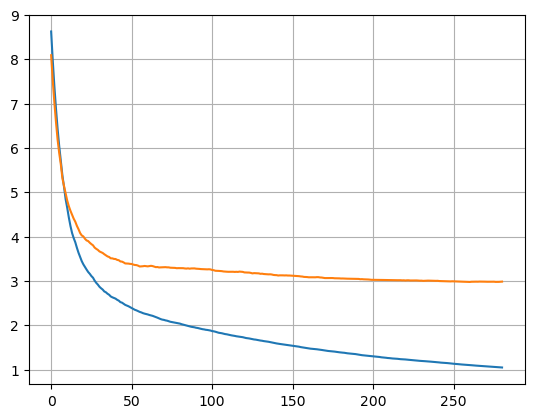

In [68]:
model.evals_result_.keys()

train_loss = model.evals_result_['training']['rmse']
test_loss = model.evals_result_['valid_1']['rmse']

plt.plot(train_loss, label='Train')
plt.plot(test_loss, label= 'Test')
plt.grid()

# Split

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

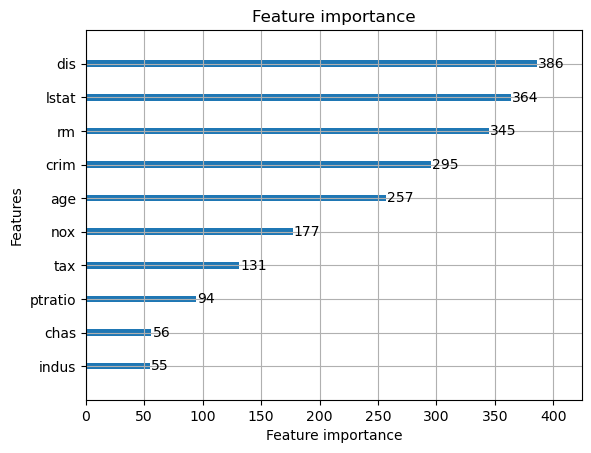

In [69]:
lgb.plot_importance(model, max_num_features=10, importance_type='split')

# Gain

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

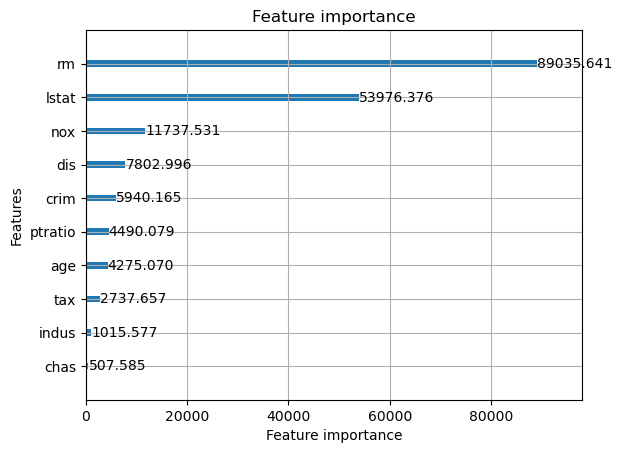

In [70]:
lgb.plot_importance(model, max_num_features=10, importance_type='gain')

# CatBoost

In [71]:
cat_cols = [col for col in X_train.columns if X_train[col].nunique() < 50]
for col in cat_cols:
    X_train[col] = X_train[col].astype(str).fillna('missing')
    X_test[col] = X_test[col].astype(str).fillna('missing')

model = CatBoostRegressor(
    iterations=10000,          
    depth=5,                
    learning_rate=0.5,
    subsample=0.25,            
    rsm=0.8,                    
    eval_metric='R2',           
    l2_leaf_reg=0.1,            
    random_strength=5,         
    verbose=100,
    early_stopping_rounds=20    
)

model.fit(
    X_train, y_train,
    cat_features=cat_cols,
    eval_set=[(X_test, y_test)],
)

# Paso 6: Evaluar
y_pred = model.predict(X_test)
print(f" R²: {r2_score(y_test, y_pred):.4f}")

0:	learn: 0.4408230	test: 0.3082501	best: 0.3082501 (0)	total: 1.26ms	remaining: 12.6s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.8299351617
bestIteration = 79

Shrink model to first 80 iterations.
 R²: 0.8299


In [72]:
df_importances = pd.DataFrame({
    'feature': model.feature_names_,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

df_importances

,feature,importance
10,lstat,28.738026
5,rm,18.084037
7,dis,10.028664
0,crim,9.743474
6,age,6.652598
4,nox,5.797813
9,ptratio,4.402445
1,zn,4.167185
2,indus,3.665665
3,chas,2.922884


# XGBoost

In [73]:
X_train = X_train.copy().astype('float')
X_test = X_test.copy().astype('float')
y_train = y_train.copy().astype('float')
y_test = y_test.copy().astype('float')

model = XGBRegressor(
    n_estimators=10000,
    max_depth=5,
    learning_rate = 0.1,
    reg_lambda=0.1,
    subsample = 0.5,
    col_sample_by_tree = 0.8,
    tree_method='hist'
)

# Haz fit, usa early stopping, verboso y evalset [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=20, verbose=100)

[09:19:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "col_sample_by_tree" } are not used.

[0]	validation_0-rmse:21.90613	validation_1-rmse:20.58609
[100]	validation_0-rmse:0.81249	validation_1-rmse:2.53266
[116]	validation_0-rmse:0.70979	validation_1-rmse:2.53236


/opt/anaconda3/lib/python3.12/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             col_sample_by_tree=0.8, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [74]:
y_pred = model.predict(X_test)
print(f" R²: {r2_score(y_test, y_pred):.4f}")

 R²: 0.9140


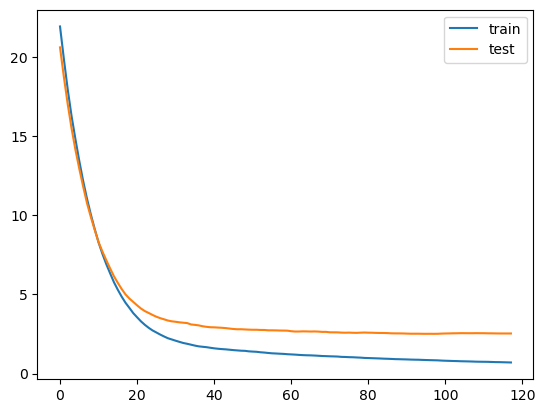

In [75]:
eval_model = model.evals_result()
train_loss = eval_model['validation_0']['rmse']
test_loss = eval_model['validation_1']['rmse']

plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend()

In [76]:
importancias = model.feature_importances_

df_importancias = pd.DataFrame({
    'features': X_test.keys(),
    'importancias': importancias
})
df_importancias = df_importancias.sort_values('importancias', ascending=False)
df_importancias

,features,importancias
10,lstat,0.275642
5,rm,0.245873
7,dis,0.065912
9,ptratio,0.056481
11,rad_1,0.047159
16,rad_6,0.040149
8,tax,0.039592
6,age,0.037014
2,indus,0.029005
0,crim,0.027469


# Weight

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

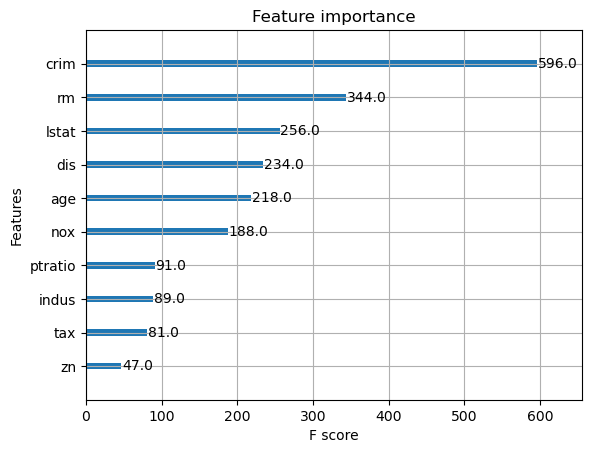

In [77]:
from xgboost import plot_importance

plot_importance(model, max_num_features=10, importance_type='weight')

# Gain

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

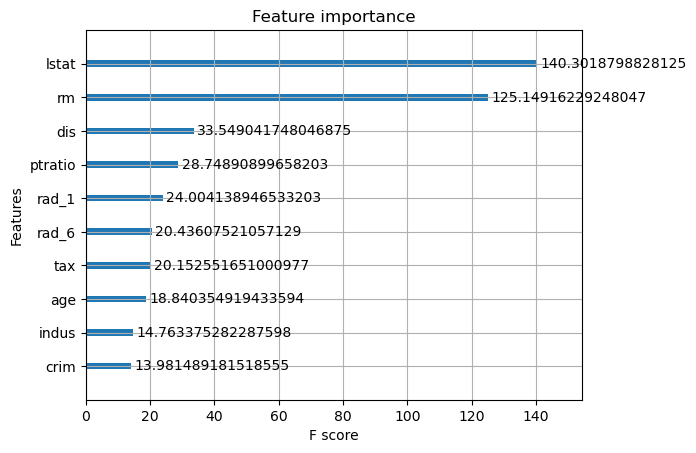

In [78]:
plot_importance(model, max_num_features=10, importance_type='gain')